##### The first few codeblocks are from the clip2brain github, the later are conjoined elements from my own notebooks. All functionality is implemented in the encoding_feats.py script as well (with some slight additions).


In [1]:
import os
import sys
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import nibabel as nib
import pickle
import torchvision.models as models
import nibabel as nib
import h5py
import scipy.stats.mstats as mstats
import copy
import yaml

from nilearn import plotting
from scipy.ndimage import binary_dilation
from PIL import Image
from importlib import reload
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator, NullFormatter
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from colorama import Fore, Style
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.impute import SimpleImputer
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from tqdm import tqdm
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from typing import Dict, Tuple, Union
from scipy.special import softmax
from scipy.stats import zscore as zs



print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from unet_recon.inpainting import UNet
from funcs.analyses import univariate_regression

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg']


In [2]:
# import numpy as np

import torch
import torch.nn as nn
from torchvision import models, transforms, utils
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
import importlib
from importlib import reload

import lgnpy.CEandSC.lgn_statistics

import funcs.natspatpred
import unet_recon.inpainting

# from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat, LGN

importlib.reload(funcs.natspatpred)
importlib.reload(unet_recon.inpainting)
importlib.reload(lgnpy.CEandSC.lgn_statistics)

from lgnpy.CEandSC.lgn_statistics import LGN, lgn_statistics, loadmat

from funcs.natspatpred import NatSpatPred, VoxelSieve
from unet_recon.inpainting import UNet

soepstengesl
soepstengesl


In [4]:
# Class from clip2brain github respository
class AlexNet(nn.Module):
    conv_layers = {"conv1": 2, "conv2": 5, "conv3": 7, "conv4": 9, "conv5": 12}
    fc_layers = {"fc6": 1, "fc7": 4}

    def __init__(self, layer, extract_conv=True):
        super(AlexNet, self).__init__()
        self.extract_conv = extract_conv
        if self.extract_conv:
            self.layer_ind = AlexNet.conv_layers[layer]
        else:
            self.layer_ind = AlexNet.fc_layers[layer]

        # load models from PyTorch
        alexnet = models.alexnet(pretrained=True)
        alexnet.to(device)
        for param in alexnet.parameters():
            param.requires_grad = False
        alexnet.eval()

        features = list(alexnet.features)
        self.features = nn.ModuleList(features).eval()
        self.adaptivepool = alexnet.avgpool
        if (
            not self.extract_conv
        ):  # if need fc layer then add those linear layers into the forward pass
            self.classifiers = nn.Sequential(
                *list(alexnet.classifier.children())
            ).eval()

    def forward(self, x, subsample, subsampling_size=20000):
        results = []
        for ii, layer in enumerate(self.features):
            x = layer(x)
            if self.extract_conv and self.layer_ind == ii:
                if subsample == "avgpool":
                    # print(x.data.shape)
                    c = x.data.shape[1]  # number of channels
                    k = int(np.floor(np.sqrt(subsampling_size / c)))
                    results = (
                        nn.functional.adaptive_avg_pool2d(x.data, (k, k))
                        .cpu()
                        .flatten()
                        .numpy()
                    )
                elif subsample == "pca":
                    if (
                        self.layer_ind == AlexNet.conv_layers["conv1"]
                    ):  # need to reduce dimension of the first layer by half for PCA
                        results = (
                            nn.functional.avg_pool2d(x.data, (2, 2))
                            .cpu()
                            .flatten()
                            .numpy()
                            .astype(np.float16)
                        )
                    else:
                        results = x.cpu().flatten().numpy().astype(np.float16)
                else:
                    results = x.cpu().flatten().numpy()
                break

        if not self.extract_conv:
            x = self.adaptivepool(x)
            x = x.view(-1)
            for ii, layer in enumerate(self.classifiers):
                x = layer(x)
                if self.layer_ind == ii:
                    results = x.view(-1).data.cpu().numpy()
                    break
        return results

In [ ]:
def get_PCs(args, data=None, return_pca_object=False):
    name_modifier = make_name_modifier(args)
    try:
        fpath = "%s/output/pca/%s/%s/pca_group_components.npy" % (
            args.output_root,
            args.model,
            name_modifier,
        )
        print("Loading PCA from: " + fpath)
        if return_pca_object:
            with open(
                "%s/output/pca/%s/%s/pca_group_components.pkl"
                % (args.output_root, args.model, name_modifier),
                "rb",
            ) as f:
                pca = pickle.load(f)
        else:
            PCs = np.load(fpath)

    except FileNotFoundError:
        output_dir = "%s/output/pca/%s/%s/" % (
            args.output_root,
            args.model,
            name_modifier,
        )
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            os.makedirs(output_dir + "pca_voxels/")

        print("Running PCA of: " + name_modifier)
        if data is None:
            data = load_weight_matrix_from_subjs_for_pca(args).T

        print("Shape of weight is:")
        print(data.shape)

        # remove outlier voxels
        print("Outlier:")
        print(data[np.where(data > 30)])

        data[np.where(data > 30)] = 0  # TODO: check why this weight is so high

        pca = PCA(n_components=args.num_pc, svd_solver="full")
        pca.fit(data)
        PCs = pca.components_
        np.save(fpath, PCs)

        with open(
            "%s/output/pca/%s/%s/pca_group_components.pkl"
            % (args.output_root, args.model, name_modifier),
            "wb",
        ) as f:
            pickle.dump(pca, f)

        plt.plot(pca.explained_variance_ratio_)
        plt.xlabel("Principal Components")
        plt.ylabel("Explained Variance")
        plt.xticks(ticks=np.arange(20) + 1)
        plt.savefig("figures/PCA/ev/%s_pca_group_%s.png" % (args.model, name_modifier))

    if return_pca_object:
        return pca, name_modifier
    else:
        return PCs, name_modifier

# Novel implementation of get_cnnfeats

In [2]:
import argparse
import os
import random
import sys
import traceback

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats.mstats as mstats
import torch
import torchvision.models as models
from matplotlib import colormaps
from PIL import Image
from scipy.stats import zscore as zs
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.feature_extraction import (create_feature_extractor,
                                                   get_graph_node_names)
from tqdm import tqdm

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)

from funcs.imgproc import get_imgs_designmx, rand_img_list, show_stim
from funcs.utility import get_zscore

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


In [48]:
# predparser = argparse.ArgumentParser(description='Get the AlexNet feature space neural representations for a range of images of a subject')

# predparser.add_argument('start', type=int, help='The starting index of the images to get the cnn layer specific neural represenations for')
# predparser.add_argument('end', type=int, help='The ending index of the images to get the cnn layer specific neural represenations  for')
# predparser.add_argument('subject', type=str, help='The subject to get the cnn layer specific neural represenations for')
# predparser.add_argument('cnn_layer', type=int, help='The layer to extract neural representations of')

# args = predparser.parse_args()

# Define the run arguments
# start = 0
# end = 10
subject = "subj01"
cnn_layer = 4
prf_region = "center_strict"

# Load the pretrained AlexNet model
model = models.alexnet(pretrained=True)
model.eval()  # Set the model to evaluation mode

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [49]:
class ImageDataset(Dataset):
    def __init__(self, image_ids, transform=None, crop:bool=False):
        self.image_ids = image_ids
        self.transform = transform
        self.crop = crop

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        if self.crop:
            imgnp = (show_stim(img_no=img_id, hide='y', small = 'y')[0][163:263,163:263])
        else:
            imgnp = show_stim(img_no=img_id, hide='y', small = 'y')[0]
            
        imgPIL = Image.fromarray(imgnp) # Convert into PIL from np

        if self.transform:
            imgPIL = self.transform(imgPIL)

        return imgPIL
    
preprocess = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]) # normalize the images color channels
])

In [33]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

this_layer = train_nodes[cnn_layer + 1]
print(f"Extracting features from layer: {this_layer}")
# Which layer to extract the features from # Also add this as argparse thing.
# model_layer = "features.2" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}

feature_extractor = create_feature_extractor(model, return_nodes=[this_layer])

start = 0
end = 500
batch_size = end - start

image_ids = get_imgs_designmx()[subject][start:end]
dataset = ImageDataset(image_ids, transform=preprocess, crop=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


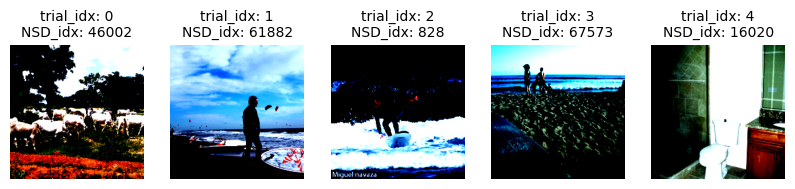

In [50]:
# Iterate over the dataloader to visualize the images
for batch_idx, batch in enumerate(dataloader):
    images = batch.numpy()  # Convert the batch tensor to numpy array
    # num_images = images.shape[0]
    num_images = 5
    trial_indices = image_ids[batch_idx * batch_size : (batch_idx + 1) * batch_size]

    # Plot the images in the batch
    fig, axes = plt.subplots(1, num_images, figsize=(10, 3))
    for i in range(num_images):
        # Transpose the image tensor to (height, width, channels)
        axes[i].imshow(images[i].transpose(1, 2, 0))
        axes[i].axis("off")
        axes[i].set_title(f"trial_idx: {i}\nNSD_idx: {trial_indices[i]}", fontsize=10)

    plt.show()

    # Ask the user if they want to see more batches or exit
    choice = input("Enter 'q' to quit or any other key to continue: ")
    if choice.lower() == "q":
        break

In [51]:
def extract_features(feature_extractor, dataloader, pca):
    while True:  # Keep trying until successful
        try:
            features = []
            for i, d in tqdm(enumerate(dataloader), total=len(dataloader)):
                # Extract features
                ft = feature_extractor(d)
                # Flatten the features
                ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])

                # Print out some summary statistics of the features
                print(
                    f"Mean: {ft.mean()}, Std: {ft.std()}, Min: {ft.min()}, Max: {ft.max()}"
                )

                # Check if the features contain NaN values
                if np.isnan(ft.detach().numpy()).any():
                    raise ValueError("NaN value detected")

                # Check for extreme outliers
                if (ft.detach().numpy() < -100000).any() or (
                    ft.detach().numpy() > 100000
                ).any():
                    raise ValueError("Extreme outlier detected before PCA fit")

                # Apply PCA transform
                ft = pca.transform(ft.cpu().detach().numpy())
                features.append(ft)
            return np.vstack(features)  # Return the features
        except ValueError as e:
            print(f"Error occurred: {e}")
            print("Restarting feature extraction...")

In [54]:
def fit_pca(feature_extractor, dataloader, pca_save_path=None):
    # Define PCA parameters
    pca = IncrementalPCA(n_components=None, batch_size=batch_size)

    try:
        # Fit PCA to batch to determine number of components
        print("Determining the number of components to maintain 95% of the variance...")
        for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
            # Extract features
            ft = feature_extractor(d)
            # Flatten the features
            ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
            
            # Check for NaN values
            if np.isnan(ft.detach().numpy().any()):
                raise ValueError("NaN value detected before PCA fit")
            
            # Check for extreme outliers
            if (ft.detach().numpy() < -100000).any() or (ft.detach().numpy() > 100000).any():
                raise ValueError("Extreme outlier detected before PCA fit")
            
            # Fit PCA to batch
            pca.partial_fit(ft.detach().cpu().numpy())

        # Calculate cumulative explained variance ratio
        cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
        # Find the number of components to maintain 95% of the variance
        n_comps = np.argmax(cumulative_var_ratio >= 0.95) + 1
        print(f'Number of components to maintain 95% of the variance: {n_comps}')

        # Set the number of components
        pca = IncrementalPCA(n_components=n_comps, batch_size=batch_size)

        # Fit PCA to the entire dataset
        print("Fitting PCA with determined number of PCs to batch...")
        for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
            # Extract features
            ft = feature_extractor(d)
            # Flatten the features
            ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
            # Fit PCA to batch
            pca.partial_fit(ft.detach().cpu().numpy())

        # Save the fitted PCA object if specified
        if pca_save_path:
            print(f"Saving fitted PCA object to: {pca_save_path}")
            joblib.dump(pca, pca_save_path)
        
        # Return the fitted PCA object
        print("PCA fitting completed.")
        return pca  

    except Exception as e:
        print(f"Error occurred: {e}")
        print("PCA fitting failed.")
        return None


Number of Principle Components required for 95% of maintained variance in cropped images.
layer1: ReLU = 285 pcs
layer4: ReLU = 
layer7: ReLU = 315 pcs (I think)
layer 

In [57]:
# Fit PCA and get the fitted PCA object
pca = fit_pca(
    feature_extractor,
    dataloader,
    pca_save_path=f"/home/rfpred/data/custom_files/visfeats/cnn_featmaps/pca_{cnn_layer}_{batch_size}.joblib",
)

Determining the number of components to maintain 95% of the variance...


100%|██████████| 1/1 [01:33<00:00, 93.24s/it]


Number of components to maintain 95% of the variance: 324
Fitting PCA with determined number of PCs to batch...


100%|██████████| 1/1 [01:34<00:00, 94.17s/it]


Saving fitted PCA object to: /home/rfpred/data/custom_files/visfeats/cnn_featmaps/pca_4_500.joblib
PCA fitting completed.


In [58]:
# Check if PCA fitting was successful
if pca is not None:
    # Apply the fitted PCA to the rest of the dataset
    features_algo = extract_features(feature_extractor, dataloader, pca)
else:
    print("PCA fitting failed. Unable to apply PCA.")

np.savez(
    f"/home/rfpred/data/custom_files/{subject}/pred/featmaps/tests/cnn_pcs_layer{this_layer}_{start}-{end}.npz",
    *features_algo,
)

print("gelukt hoor")

  0%|          | 0/1 [00:00<?, ?it/s]

Mean: 0.5003709197044373, Std: 1.2574344873428345, Min: 0.0, Max: 38.9945068359375


100%|██████████| 1/1 [00:10<00:00, 10.65s/it]

gelukt hoor


In [59]:
# Load in the saved pca.joblib again
from joblib import load
pca_retrieved = load(f'/home/rfpred/data/custom_files/visfeats/cnn_featmaps/pca_{cnn_layer}_{batch_size}.joblib')

In [62]:
pca_retrieved.components_.shape



(324, 193600)

## VGG-b Encoding Implementation

In [2]:
import joblib
import torch
import torch.nn as nn
from torchvision import models, transforms, utils
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
import os
from classes.natspatpred import NatSpatPred
NSP = NatSpatPred()
NSP.initialise()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils
cpu


In [7]:
all_img_ids = list(NSP.stimuli.imgs_designmx()["subj01"])
all_img_ids


# list(range(0,10))

[46002,
 61882,
 828,
 67573,
 16020,
 40422,
 51517,
 62325,
 50610,
 55065,
 37398,
 18039,
 67533,
 21822,
 35405,
 21690,
 28278,
 10459,
 2293,
 44325,
 38218,
 30032,
 65255,
 64919,
 12469,
 43078,
 8926,
 9860,
 48617,
 18699,
 52707,
 65060,
 47923,
 54482,
 58816,
 44980,
 12258,
 2548,
 11018,
 23358,
 39386,
 17681,
 61819,
 571,
 32625,
 28278,
 17497,
 50802,
 36628,
 22268,
 27745,
 18468,
 34051,
 15555,
 17303,
 53052,
 4930,
 43898,
 3371,
 17952,
 31927,
 50005,
 35618,
 4996,
 3585,
 33483,
 2813,
 17304,
 3585,
 27901,
 34023,
 17668,
 7160,
 27204,
 45699,
 6124,
 45318,
 42194,
 15284,
 13758,
 45721,
 25279,
 52865,
 39789,
 7188,
 23748,
 44085,
 27605,
 33364,
 7264,
 32625,
 65972,
 14818,
 60123,
 42725,
 50102,
 21683,
 31968,
 25260,
 11880,
 13299,
 68508,
 18656,
 38924,
 15721,
 15761,
 49170,
 33483,
 26185,
 70468,
 4695,
 204,
 3390,
 69027,
 19763,
 44360,
 47125,
 33466,
 40933,
 67444,
 6431,
 15761,
 2019,
 2293,
 25406,
 4776,
 70335,
 27358,
 2

In [172]:
# Load in pretrained model from torch

model_alex = models.alexnet(pretrained=True)
model_alex.eval()  # Set the model to evaluation mode
# modeltype = model._get_name()

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
# Load in pretrained model from torch

model = models.vgg16_bn(pretrained=True)
model.eval()  # Set the model to evaluation mode
modeltype = model._get_name()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [62]:
class ImageDataset(Dataset):
    def __init__(self, image_ids, transform=None, crop: bool = True):
        self.image_ids = image_ids
        self.transform = transform
        self.crop = crop

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        if self.crop:
            imgnp = NSP.stimuli.show_stim(img_no=img_id, hide=True, small=True, crop=False)[0][
                163:263, 163:263
            ]  # I CROP THEM, YOU SEE
        else:
            imgnp = NSP.stimuli.show_stim(img_no=img_id, hide=True, small=True, crop=False)[0]

        imgPIL = Image.fromarray(imgnp)  # Convert into PIL from np

        if self.transform:
            imgPIL = self.transform(imgPIL)

        return imgPIL


preprocess = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # resize the images to 224x24 pixels
        transforms.ToTensor(),  # convert the images to a PyTorch tensor
        transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        ),  # normalize the images color channels
    ]
)

In [167]:
cnn_layer = 9

train_nodes, _ = get_graph_node_names(model)
print(train_nodes)
print(f"Running encoding analysis for layer: {train_nodes[cnn_layer + 1]}")
this_layer = train_nodes[cnn_layer + 1]

# Which layer to extract the features from # Also add this as argparse thing.
# model_layer = "features.2" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}

feature_extractor = create_feature_extractor(model, return_nodes=[this_layer])

train_batch = 50
apply_batch = 50  # The image batch over which the fitted PCA is applied later on.
fixed_n_comps = 50

# image_ids = get_imgs_designmx()[subject][start:end] # This was for subject-specific image indices. Current line (below) is for all images.
image_ids = list(range(0, train_batch))
dataset = ImageDataset(image_ids, transform=preprocess, crop=False) # CHECK THIS CROP ARG
dataloader = DataLoader(dataset, batch_size=train_batch, shuffle=False)


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'features.31', 'features.32', 'features.33', 'features.34', 'features.35', 'features.36', 'features.37', 'features.38', 'features.39', 'features.40', 'features.41', 'features.42', 'features.43', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Running encoding analysis for layer: features.9


In [65]:
def extract_features(feature_extractor, dataloader, pca, cnn_layer: int):
    while True:  # Keep trying until successful
        try:
            features = []
            for i, d in tqdm(enumerate(dataloader), total=len(dataloader)):
                # Extract features
                ft = feature_extractor(d)
                # Flatten the features
                ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])

                # Print out some summary statistics of the features
                print(
                    f"AlexNet layer: {cnn_layer}, Mean: {ft.mean()}, Std: {ft.std()}, Min: {ft.min()}, Max: {ft.max()}"
                )

                # Check if the features contain NaN values
                if np.isnan(ft.detach().numpy()).any():
                    raise ValueError("NaN value detected")

                # Check for extreme outliers
                if (ft.detach().numpy() < -100000).any() or (
                    ft.detach().numpy() > 100000
                ).any():
                    raise ValueError("Extreme outlier detected before PCA fit")

                # Apply PCA transform
                ft = pca.transform(ft.cpu().detach().numpy())
                features.append(ft)
            return np.vstack(features)  # Return the features
        except ValueError as e:
            print(f"Error occurred: {e}")
            print("Restarting feature extraction...")


def extract_features_and_check(d, feature_extractor):
    while True:  # Keep trying until successful
        try:
            # Extract features
            ft = feature_extractor(d)
            # Flatten the features
            ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])

            # Check for NaN values
            if np.isnan(ft.detach().numpy().any()):
                raise ValueError("NaN value detected before PCA fit")

            # Check for extreme outliers
            if (ft.detach().numpy() < -100000).any() or (ft.detach().numpy() > 100000).any():
                raise ValueError("Extreme outlier detected before PCA fit")

            return ft  # If everything is fine, return the features

        except ValueError as e:
            print(f"Error occurred: {e}")
            print("Restarting feature extraction...")


def fit_pca(
    feature_extractor,
    dataloader,
    pca_save_path=None,
    fixed_n_comps: int | None = None,
    train_batch: int = None,
    return_rawfeats: bool = False
):
    """
    Fits a PCA (Principal Component Analysis) model to the given dataset.

    Args:
        feature_extractor: The feature extractor used to extract features from the dataset.
        dataloader: The dataloader containing the dataset.
        pca_save_path: Optional. The file path to save the fitted PCA object.
        fixed_n_comps: Optional. The fixed number of components to use for PCA.
        train_batch: Optional. The batch size for training PCA.

    Returns:
        The fitted PCA object.

    Raises:
        Exception: If an error occurs during PCA fitting.

    """
    
    # Define PCA parameters
    pca = IncrementalPCA(n_components=None, batch_size=train_batch)

    try:
        if fixed_n_comps is None:
            # Fit PCA to batch to determine number of components
            print(
                "Determining the number of components to maintain 95% of the variance..."
            )
            for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
                ft = extract_features_and_check(d, feature_extractor)
                # Fit PCA to batch
                pca.partial_fit(ft.detach().cpu().numpy())

            # Calculate cumulative explained variance ratio
            cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
            # Find the number of components to maintain 95% of the variance
            n_comps = np.argmax(cumulative_var_ratio >= 0.95) + 1
            print(f"Number of components to maintain 95% of the variance: {n_comps}")

        else:
            n_comps = fixed_n_comps
            print(f"Using fixed number of components: {n_comps}")

        # Set the number of components
        pca = IncrementalPCA(n_components=n_comps, batch_size=train_batch)

        # Fit PCA to the entire dataset
        print("Fitting PCA with determined number of PCs to batch...")
        for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
            ft = extract_features_and_check(d, feature_extractor)
            # Fit PCA to batch
            pca.partial_fit(ft.detach().cpu().numpy())

        # Save the fitted PCA object if specified
        if pca_save_path:
            print(f"Saving fitted PCA object to: {pca_save_path}")
            joblib.dump(pca, pca_save_path)


        if return_rawfeats:
            return pca, ft
        else:
            # Return the fitted PCA object
            print("PCA fitting completed.")
            return pca

    except Exception as e:
        print(f"Error occurred: {e}")
        print("PCA fitting failed.")
        return None
    


In [168]:
os.makedirs(f"{NSP.own_datapath}/visfeats/cnn_featmaps/{modeltype}/", exist_ok=True)
# Fit PCA and get the fitted PCA object
pca, ft = fit_pca(
    feature_extractor,
    dataloader,
    # pca_save_path=f"/home/rfpred/data/custom_files/visfeats/cnn_featmaps/pca_{args.cnn_layer}_{fixed_n_comps}pcs.joblib",
    pca_save_path=f"{NSP.own_datapath}/visfeats/cnn_featmaps/{modeltype}/pca_smallpatch_{cnn_layer}_{fixed_n_comps}pcs.joblib",
    fixed_n_comps=fixed_n_comps,
    train_batch=train_batch,
    return_rawfeats=True
)

Using fixed number of components: 50
Fitting PCA with determined number of PCs to batch...


100%|██████████| 1/1 [00:20<00:00, 20.27s/it]


Saving fitted PCA object to: /home/rfpred/data/custom_files/visfeats/cnn_featmaps/VGG/pca_smallpatch_9_50pcs.joblib


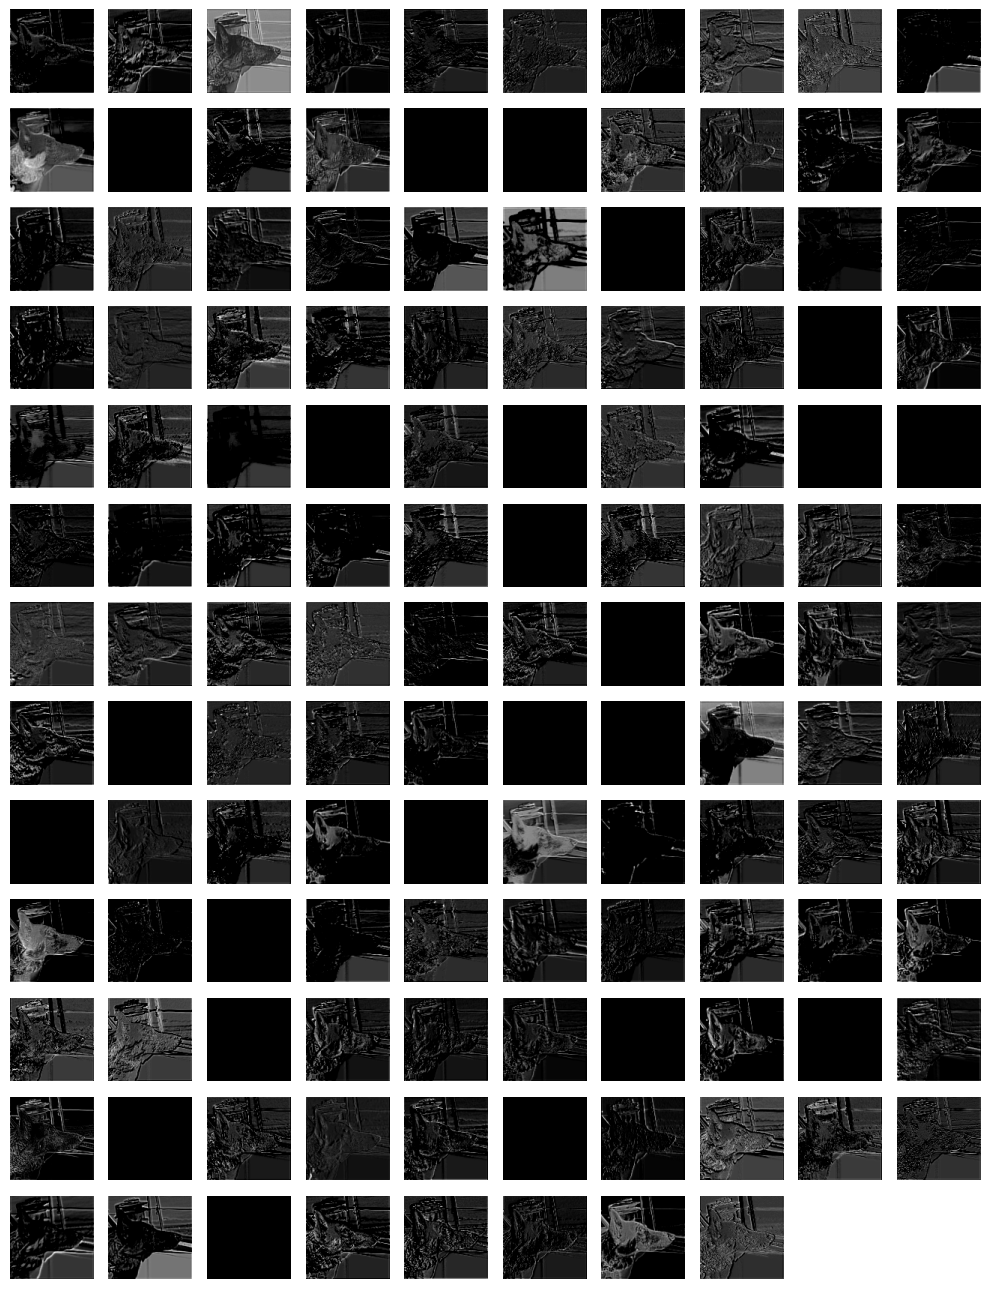

In [169]:
feat_maps = ft.detach().cpu().numpy()
resize_factor = 2 # The factor by which to resize the feature maps, becomes higher the more 
# convolutions have been applied, as the spatial dimensions decrease because you use kernels.

dims = int(224/resize_factor) # 
num_maps = int(feat_maps[2].shape[0]/(dims * dims))
feat_maps_rs = feat_maps[random.randint(0,49)].reshape((num_maps, dims,dims))
num_cols = 10
random_cmap=False

# Number of rows in the subplot grid
num_rows = num_maps // num_cols
if num_maps % num_cols:
    num_rows += 1
    
    cmaps = list(colormaps)
this_cmap = cmaps[random.randint(0, len(cmaps))] if random_cmap else 'binary_r'
if random_cmap:
    print (f'The Lord has decided for you to peek into feature space through the lens of {this_cmap}')

figsize = (num_cols, num_rows)
plt.figure(figsize=figsize)

# Plot each feature map
for i in range(num_maps):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(feat_maps_rs[i], cmap=this_cmap)
    plt.axis('off')
    
# Show the plot
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout()
plt.show()


(-0.5, 111.5, 111.5, -0.5)

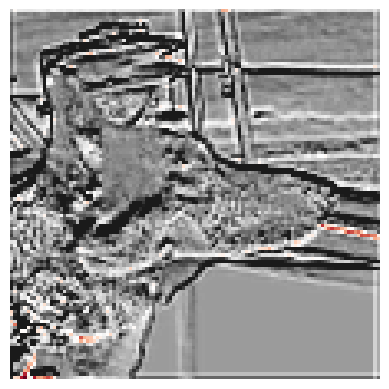

In [170]:
plt.imshow(feat_maps_rs[7], cmap='RdGy_r')
plt.axis('off')

In [52]:
# del dataloader, dataset

# Redefine the dataset and dataloader with the entire image set to apply the fitted PCA to.
# all_img_ids = list(range(0, 73000))  # All the NSD images
all_img_ids = list(range(0, 50))  # Selection of the NSD images
full_dataset = ImageDataset(all_img_ids, transform=preprocess, crop=False)
full_dataloader = DataLoader(full_dataset, batch_size=apply_batch, shuffle=False)

# Check if PCA fitting was successful
if pca is not None:
    # Apply the fitted PCA to the rest of the dataset
    features_algo = extract_features(
        feature_extractor, full_dataloader, pca, cnn_layer
    )
else:
    print("PCA fitting failed. Unable to apply PCA.")


os.makedirs(f"{NSP.own_datapath}/visfeats/cnn_featmaps/{modeltype}/featmaps/", exist_ok=True)

np.savez(
    # f"/home/rfpred/data/custom_files/visfeats/cnn_featmaps/featmaps/featmaps_lay{this_layer}.npz",
    f"{NSP.own_datapath}/visfeats/cnn_featmaps/{modeltype}/featmaps/featmaps_smallpatch_lay{this_layer}.npz",
    *features_algo,
)

print("Het is je gelukt, compagnon")

  0%|          | 0/1 [00:00<?, ?it/s]

AlexNet layer: 2, Mean: 0.09039099514484406, Std: 0.2118329554796219, Min: 0.0, Max: 8.29652214050293


100%|██████████| 1/1 [00:02<00:00,  2.90s/it]

Het is je gelukt, compagnon


In [58]:
features_algo[0].



(50,)